# Batch Multivalid Conformal Prediction (BatchMVP)

In this notebook we showcase the usage of BatchMVP [[Jung C. et al., 2022]](https://arxiv.org/pdf/2209.15145.pdf), a conformal prediction algorithm that satisfies coverage guarantees conditioned on group membership and non-conformity thresholds. 

To make it concrete, suppose that, for your application, you do not only care about marginal calibration over the full input domain, say $\mathbb{R}$, but you specifically want to ensure marginal coverage on both sub-domains $\mathbb{R}_-$ and $\mathbb{R}_+$. This property is usually not guaranteed by standard conformal prediction methods that satisfy only marginal coverage. In fact, a method may overcover on $\mathbb{R}_-$ and undercover on $\mathbb{R}_+$, and yet satisfy marginal coverage overall.

We study this problem exactly in a simple regression setting, where data in $\mathbb{R}_+$ is far more noisy than in $\mathbb{R}_-$. The next cell provides functionality to generate the data and plot some intervals.

In [1]:
import numpy as np

def generate_data(n_data: int, sigma1=0.03, sigma2=0.5):
    x = np.concatenate([
        np.random.normal(loc=-1, scale=0.3, size=(n_data // 2, 1)),
        np.random.normal(loc=1, scale=0.3, size=(n_data - n_data // 2, 1))
    ])
    y = np.cos(x) + np.concatenate([
        np.random.normal(scale=sigma1, size=(n_data // 2, 1)),
        np.random.normal(scale=sigma2, size=(n_data - n_data // 2, 1))
    ])
    return x, y

def plot_intervals(xx, means, intervals, test_data, method):
    plt.figure(figsize=(6, 3))
    plt.plot(xx, xx_means, label="predictions")
    plt.scatter(*test_data, label="test data", c="C3", s=1)
    plt.fill_between(xx.squeeze(1), intervals[:, 0], intervals[:, 1], alpha=0.3, color="C0", label="95% intervals")
    plt.vlines(0, -1, 1.5, linestyle="--", color="black", label="groups: x < 0 and x > 0")
    plt.ylim([-1, 1.5])
    plt.title(method)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc="lower left")
    plt.grid();

## Generate and prepare the data

Let us first generate training, calibration and test data points.

In [2]:
train_data = generate_data(10000)
calib_data = generate_data(1000)
test_data = generate_data(1000)

We then plot the training data. We see that when $x<0$ the data is much less noisy than when $x>0$.

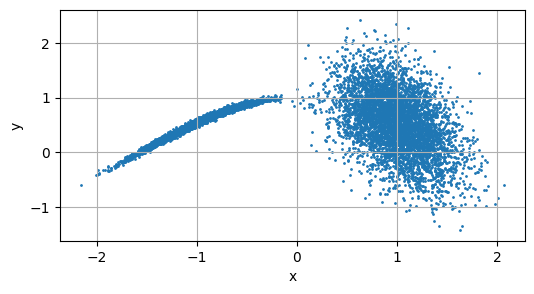

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.scatter(*train_data, s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

We then use Fortuna to transfom these arrays of data into a data loader, in order to be able to feed data to algorithms in batches.

In [4]:
from fortuna.data import DataLoader
train_data_loader = DataLoader.from_array_data(train_data, batch_size=128, shuffle=True, prefetch=True)
calib_data_loader = DataLoader.from_array_data(calib_data, batch_size=128, prefetch=True)
test_data_loader = DataLoader.from_array_data(test_data, batch_size=128, prefetch=True)

test_inputs_loader = test_data_loader.to_inputs_loader()
test_targets = test_data_loader.to_array_targets()
calib_inputs_loader = calib_data_loader.to_inputs_loader()
calib_targets = calib_data_loader.to_array_targets()

## Groups definition

We now rigorously define the two groups of inputs that we are going to consider, specifically $\mathbb{R}_-$ and $\mathbb{R}_+$. We define these in terms of boolean group functions. These will be used later by `BatchMVP`.

In [5]:
group_fns = [lambda x: x.squeeze(1) < 0, lambda x: x.squeeze(1) >= 0]
idx_left, idx_right = [group_fns[i](test_data[0]) for i in range(2)]

## Credible intervals with SWAG

We start by training a probabilistic classifier based on a MultiLayer Perceptron (MLP) model. Under the hood, posterior inference is performed by SWAG [Maddox W. J. et al., 2019](https://proceedings.neurips.cc/paper/2019/hash/118921efba23fc329e6560b27861f0c2-Abstract.html).

In [6]:
from fortuna.prob_model import ProbRegressor
from fortuna.model import MLP
prob_model = ProbRegressor(model=MLP(1), likelihood_log_variance_model=MLP(1))
status = prob_model.train(train_data_loader)

Epoch: 100 | loss: -9067.18945: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.05it/s]
Epoch: 100 | loss: -413.05856: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.27it/s]


We then compute predictive mean and 95% credible intervals, and we measure marginal coverage on the full domain and on each of the two groups. We notice that the method tend to undercover overall and also on each group, compared to the desired coverage of 95%. Better hyper-parameter configurations and generating more samples to compute statistics may help achieve a better coverage already, but for the purpose of this example we will directly look at how to calibrate it with conformal prediction methods.

In [7]:
from fortuna.metric.regression import picp
test_means = prob_model.predictive.mean(test_inputs_loader)
test_cred_intervals = prob_model.predictive.credible_interval(test_inputs_loader)

cred_coverage = picp(*test_cred_intervals.T, test_targets)
cred_coverage_left = picp(*test_cred_intervals[idx_left].T, test_targets[idx_left])
cred_coverage_right = picp(*test_cred_intervals[idx_right].T, test_targets[idx_right])
print(f"Estimated marginal coverage of SWAG: {cred_coverage}.")
print(f"Estimated coverage of SWAG for negative inputs: {cred_coverage_left}.")
print(f"Estimated coverage of SWAG for positive inputs: {cred_coverage_right}.")

Estimated marginal coverage of SWAG: 0.9170000553131104.
Estimated coverage of SWAG for negative inputs: 0.9240000247955322.
Estimated coverage of SWAG for positive inputs: 0.9100000262260437.


But first, let us visualize predictions and uncertainty! Although the metrics above told us that we are slightly undercovering, uncertainty estimates look quite good already.

In [8]:
from fortuna.data import InputsLoader
xx = np.linspace(test_data[0].min(), test_data[0].max())[:, None]
xx_loader = InputsLoader.from_array_inputs(xx)
xx_means = prob_model.predictive.mean(xx_loader)

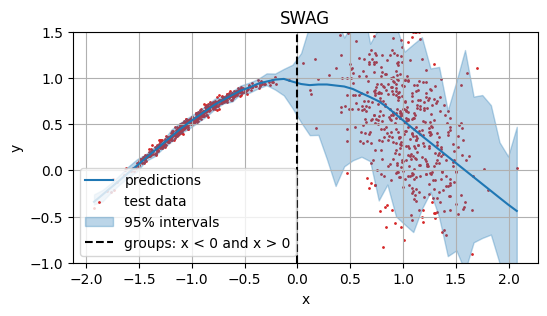

In [9]:
xx_cred_intervals = prob_model.predictive.credible_interval(xx_loader)
plot_intervals(xx, xx_means, xx_cred_intervals, test_data, "SWAG")

## Conformalized Quantile Regression

Starting from the credible intervals given by SWAG, we now apply Conformalized Quantile Regression (CQR) [[Romano Y. et al., 2019]](https://proceedings.neurips.cc/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf) as a *post-hoc* calibration method to improve the coverage. 

In [10]:
from fortuna.conformal.regression import QuantileConformalRegressor
calib_cred_intervals = prob_model.predictive.credible_interval(inputs_loader=calib_inputs_loader)
test_qcr_intervals = QuantileConformalRegressor().conformal_interval(
    *calib_cred_intervals.T, *test_cred_intervals.T, calib_targets, error=0.05
)

The following cell shows that yes, the overall marginal coverage is now closer to the desired 95%. However, CQR tends to overcover for negative inputs and undercover for positive inputs. This is not surprising, as CQR does not necessarily satisfy group-conditional coverage.

In [11]:
qcr_coverage = picp(*test_qcr_intervals.T, test_targets)
idx_left, idx_right = [group_fns[i](test_data[0]) for i in range(2)]
qcr_coverage_left = picp(*test_qcr_intervals[idx_left].T, test_targets[idx_left])
qcr_coverage_right = picp(*test_qcr_intervals[idx_right].T, test_targets[idx_right])
print(f"Estimated marginal coverage with CQR: {qcr_coverage}.")
print(f"Estimated coverage for the negative inputs with CQR: {qcr_coverage_left}.")
print(f"Estimated coverage for the positive inputs with CQR: {qcr_coverage_right}.")

Estimated marginal coverage with CQR: 0.9570000171661377.
Estimated coverage for the negative inputs with CQR: 0.9920000433921814.
Estimated coverage for the positive inputs with CQR: 0.9220000505447388.


Again, we visualize the uncertainty. Notice that, for the negative inputs, the coverage is over the desired 95%, while for positive inputs it is a little too low.

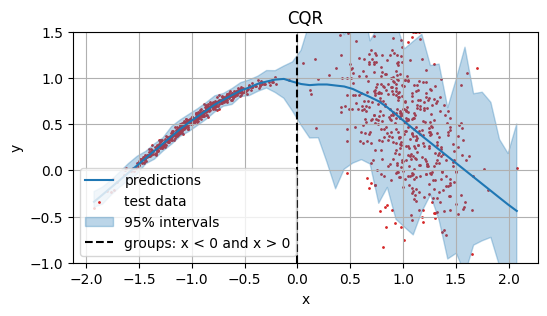

In [12]:
xx_qcr_intervals = QuantileConformalRegressor().conformal_interval(
    *calib_cred_intervals.T, *xx_cred_intervals.T, calib_targets, error=0.05
)
plot_intervals(xx, xx_means, xx_qcr_intervals, test_data, "CQR")

# Batch MVP

We finally introduce Batch MVP [[Jung C. et al., 2022]](https://arxiv.org/pdf/2209.15145.pdf) and show that it improves group-conditional coverage. For its usage, we require:

- a valid non-conformity score function. This can be any score function measuring the degree of non-conformity between inputs $x$ and targets $y$. The less $x$ and $y$ conform with each other, the larger the score should be. A simple example of score function in regression is $s(x,y)=|y - h(x)|$, where $h$ is an arbitrary model. For the purpose of this example, we use the same score function as in CQR, that is $s(x,y)=\max\left(q_{\frac{\alpha}{2}} - y, y - q_{1 - \frac{\alpha}{2}}\right)$, where $\alpha$ is the desired coverage error, i.e. $\alpha=0.05$, and $q_\alpha$ is a corresponding quantile.

- the group functions. These construct sub-domains of interest of the input domain. As we defined above, here we use $g_1(x) = \mathbb{1}[x < 0]$ and $g_2(x) = \mathbb{1}[x \ge 0]$.

- the bounds function. This is a function $b(x, \tau)$ that simultaneously defines the lower and upper bounds of the conformal interval given an input $x$ and a threshold $\tau$. For example, for the score function in use, we have $b(x, \tau) = [q_{\frac{\alpha}{2}} - \tau, q_{1 - \frac{\alpha}{2}} + \tau]$. Please notice that the bounds function is related to the inverse score function with respect to $y$. In fact, it defines the two extreme values of $y$ that satisfy the relation $s(x, y) \le \tau$.

That's it! Defined these, we are ready to run `BatchMVP`.

In [13]:
from fortuna.conformal.regression.batch_mvp import BatchMVPConformalRegressor
import jax.numpy as jnp
def score_fn(x, y):
    qleft, qright = prob_model.predictive.quantile([0.05 / 2, 1 - 0.05 / 2], InputsLoader.from_array_inputs(x))
    return jnp.maximum(qleft - y, y - qright).squeeze(1)
def bounds_fn(x, t):
    qleft, qright = prob_model.predictive.quantile([0.05 / 2, 1 - 0.05 / 2], InputsLoader.from_array_inputs(x))
    return qleft.squeeze(1) - t, qright.squeeze(1) + t
    
batchmvp = BatchMVPConformalRegressor(score_fn=score_fn, group_fns=group_fns, bounds_fn=bounds_fn)
test_batchmvp_intervals, max_calib_errors = batchmvp.conformal_interval(calib_data_loader, test_inputs_loader, return_max_calib_error=True)

At each iteration, `BatchMVP` we compute the maximum calibration error over the different groups. We report its decay in the following picture.

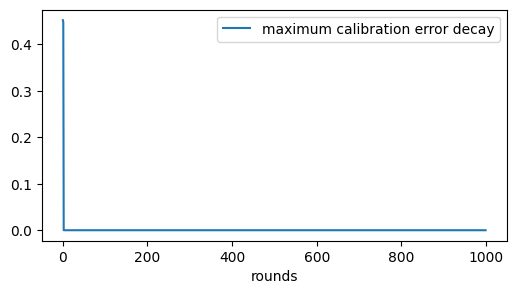

In [14]:
plt.figure(figsize=(6, 3))
plt.plot(max_calib_errors, label="maximum calibration error decay")
plt.xlabel("rounds")
plt.legend()

We now compute coverage metrics. As expected, `BatchMVP` not only provides a good marginal coverage overall, but also improves coverage on both negative and positive inputs.

In [15]:
batchmvp_coverage = picp(*test_batchmvp_intervals.T, test_targets)
batchmvp_coverage_left = picp(*test_batchmvp_intervals[idx_left].T, test_targets[idx_left])
batchmvp_coverage_right = picp(*test_batchmvp_intervals[idx_right].T, test_targets[idx_right])
print(f"Estimated marginal coverage of BatchMVP: {batchmvp_coverage}.")
print(f"Estimated coverage of BatchMVP for negative inputs: {batchmvp_coverage_left}.")
print(f"Estimated coverage of BatchMVP for positive inputs: {batchmvp_coverage_right}.")

Estimated marginal coverage of BatchMVP: 0.9550000429153442.
Estimated coverage of BatchMVP for negative inputs: 0.9520000219345093.
Estimated coverage of BatchMVP for positive inputs: 0.9580000638961792.


Once again, we visualize predictions and estimated intervals.

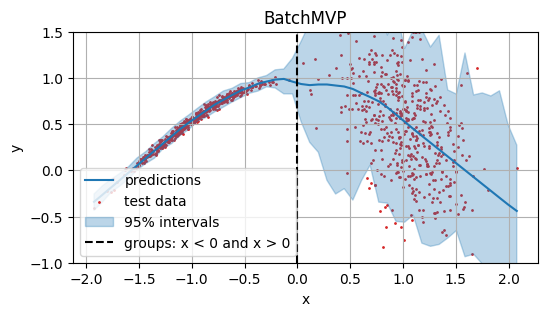

In [16]:
xx_batchmvp_intervals = batchmvp.conformal_interval(calib_data_loader, xx_loader)
plot_intervals(xx, xx_means, xx_batchmvp_intervals, test_data, "BatchMVP")